In [1]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('C:/Users/rodia/PycharmProjects/pythonProject/image_data.csv')
print(data.head())

                                      Filename  Steering Angle
0  captured_images/2024-06-20 21-53-24-316.png   -1.175409e-15
1  captured_images/2024-06-20 21-53-24-954.png   -8.474230e-12
2  captured_images/2024-06-20 21-53-25-195.png    6.155423e-11
3  captured_images/2024-06-20 21-53-25-283.png    1.033996e-10
4  captured_images/2024-06-20 21-53-25-484.png    2.163849e-10


In [3]:
def load_image(filepath):
    return cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
data['image'] = data['Filename'].apply(load_image)

In [4]:
print(f"Total images loaded: {len(data)}")

Total images loaded: 3166


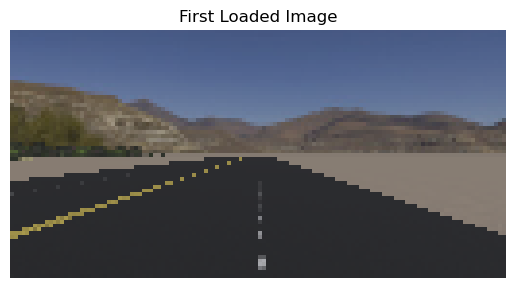

In [5]:
plt.imshow(data.iloc[0]['image'])
plt.title('First Loaded Image')
plt.axis('off')  # Oculta los ejes
plt.show()

In [6]:
train_samples, validation_samples = train_test_split(data, test_size=0.2)

In [7]:
import cv2
import numpy as np

def augment_image(image):
    # Rotación aleatoria (comentado actualmente)
    # if np.random.rand() > 0.5:
    #     angle = np.random.uniform(-10, 10)
    #     h, w = image.shape[:2]
    #     M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    #     image = cv2.warpAffine(image, M, (w, h))
    
    # Cambio de brillo
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.4, 1.5)
        image = np.clip(image * factor, 0, 255)
    
    # Volteo horizontal
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)
    
    return image

def data_generator(data, batch_size=32):
    while True:
        data = data.sample(frac=1)  # Reordenar los datos en cada época
        for offset in range(0, len(data), batch_size):
            batch_samples = data.iloc[offset:offset+batch_size]
            images = []
            angles = []
            for _, row in batch_samples.iterrows():
                image = row['image']
                angle = row['Steering Angle']
                
                # Aplicar data augmentation
                image = augment_image(image)
                image = cv2.resize(image, (200, 66))
                
                # Opcional: Convertir a YUV si el modelo fue entrenado con imágenes YUV
                # image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                
                # Normalizar la imagen
                image = (image / 255.0) - 0.5

                # Añadir imagen y ángulo al lote
                images.append(image)
                angles.append(angle)
            
            # Convertir listas a numpy arrays
            images = np.array(images)
            angles = np.array(angles)
            yield images, angles


In [8]:
def custom_lambda_function(x):
    return (x / 255.0) - 0.5  # Asumiendo que tu función lambda hace algo así.

model = Sequential([
    #Lambda(custom_lambda_function, input_shape=(66, 200, 3)),  # Normalización y definición del tamaño de entrada
    Conv2D(24, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(36, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(48, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),  # Aplanamiento de los datos para pasar de convolucional a densa
    Dense(1164, activation='relu'),  # Ajustar el número de neuronas si es necesario
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)  # Salida
])
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
train_generator = data_generator(train_samples, batch_size=32)
val_generator = data_generator(validation_samples, batch_size=32)

In [11]:
for images, angles in train_generator:
    print(images.shape)  # Debería imprimir algo como (batch_size, 66, 200, 3)
    break

(32, 66, 200, 3)


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_samples) // 32,
    validation_data=val_generator,
    validation_steps=len(validation_samples) // 32,
    epochs=10,
    verbose=1
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 8.5605e-04 - val_loss: 9.8625e-04


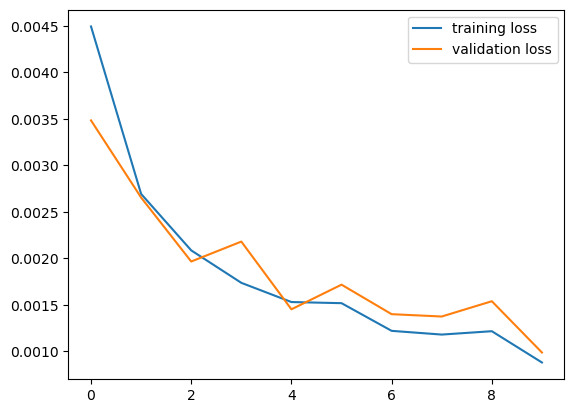

In [13]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [14]:
print("Evaluating model...")
model.evaluate(val_generator, steps=len(validation_samples) // 32)

Evaluating model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.4286e-04


0.0009141340851783752

In [15]:
model.save('behavioural_cloning_model.keras')

In [17]:
# Cargar el modelo
model = load_model('behavioural_cloning_model.keras')

NameError: name 'load_model' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


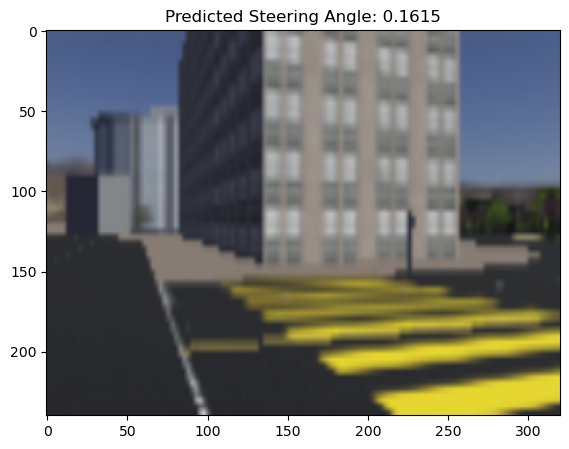

In [23]:
# Función para cargar y preprocesar la imagen
def load_and_preprocess_image(image_path):
    # Cargar la imagen
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    
    # Redimensionar la imagen para que coincida con la entrada del modelo
    img_resized = cv2.resize(img, (200, 66))
    
    # Normalizar la imagen
    img_normalized = img_resized / 255.0 - 0.5
    
    # Añadir una dimensión de batch
    img_batch = np.expand_dims(img_normalized, axis=0)
    return img_batch

# Ruta a tu imagen
image_path = 'captured_images/2024-06-20 21-55-10-159.png'

# Cargar y preprocesar la imagen
prepared_image = load_and_preprocess_image(image_path)

# Obtener la predicción del modelo
predicted_steering_angle = model.predict(prepared_image)[0][0]

# Mostrar la imagen y la predicción
plt.figure(figsize=(10, 5))
# Primero convertir la imagen normalizada de vuelta a uint8
image_to_show = (prepared_image[0] + 0.5) * 255.0
image_to_show = np.clip(image_to_show, 0, 255).astype('uint8')
image_to_show = cv2.resize(image_to_show, (320, 240))  # Opcional: Cambiar el tamaño para la visualización
plt.imshow(image_to_show)  # Mostrar usando matplotlib
plt.title(f"Predicted Steering Angle: {predicted_steering_angle:.4f}")
plt.show()